# Approach:

1. Explore data. Visualize data to see any initial trends.
2. Train model to learn features within images. How do we know we have a good model?
3. Extract features from the last fully connected layer of the model before classication output.
4. Compare among features using similarity metric. In this case, we will use cosine similarity.

In [1]:
#Import necessary libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import seaborn as sns
import random
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
import tensorflow as tf
from plotting import plot_confusion_matrix, plot_multiclass_pr_curves

sns.set()

In [2]:
#If GPU available, it will appear in brackets. Otherwise, default to CPU.
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# 1. Data Exploration

In [10]:
#Within data directory, check to see size of folders.
data_dir = "./data"

subfolders = [f for f in os.listdir(data_dir)]
print('Class  |  Images')
print('----------------')
for subfolder in subfolders:
    print(subfolder, '|', len(os.listdir(os.path.join(data_dir,subfolder))))

Class  |  Images
----------------
andesite | 5000
gneiss | 5000
marble | 4998
quartzite | 5000
rhyolite | 5000
schist | 5000


#### Since the class sizes are mostly identical, we can safely assume they are balanced.

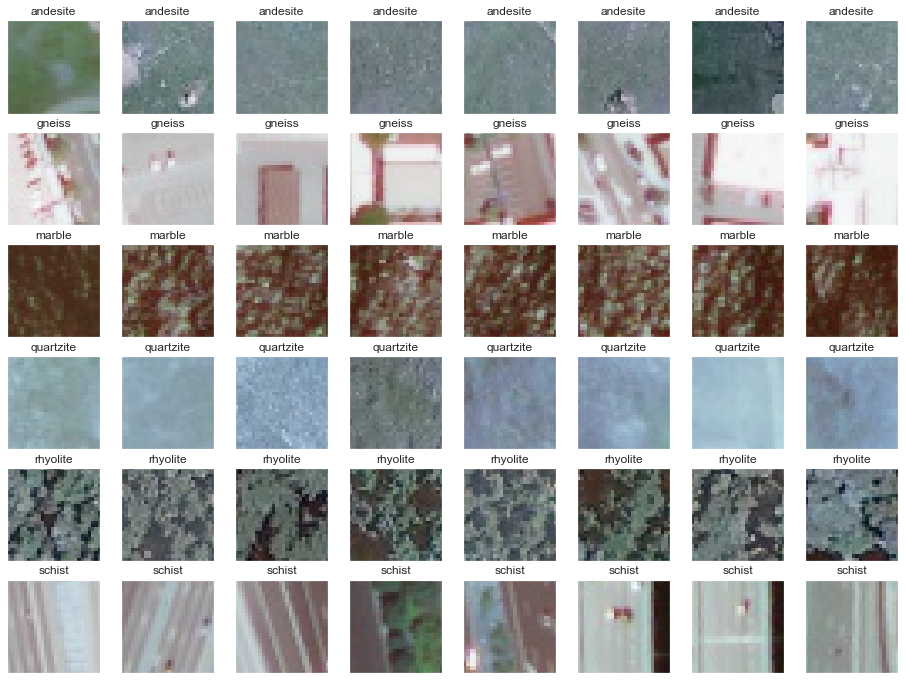

In [4]:
#Select n random images from each folder in directory to display.
def plot_rnd_images(base_dir, n):
    subfolders = [f for f in os.listdir(base_dir)]
    
    fig, ax = plt.subplots(6, n, figsize=(n*2,12))
    for r_id, folder in enumerate(subfolders):
        folder_path = os.path.join(base_dir, folder)
        files = [os.path.join(folder_path, f) for f in os.listdir(folder_path)]
        rnd_files = random.sample(files, n)
        for c_id, file in enumerate(rnd_files):
            img = mpimg.imread(file)
            ax[r_id,c_id].imshow(img)
            ax[r_id,c_id].set_xticks([])
            ax[r_id,c_id].set_yticks([])
            ax[r_id,c_id].set_title(folder)
    plt.show()
    
plot_rnd_images(data_dir, 8)

In [11]:
#Create dataframe with columns:
# Path (str)
# Label (str)
def paths_to_df(base_dir):
    paths, labels = [],[]
    
    for folder in os.listdir(base_dir):
        folder_path = os.path.join(base_dir, folder)
        paths += [os.path.join(folder_path, f) for f in os.listdir(folder_path)]
        labels += [folder]*len(os.listdir(folder_path))
    df = pd.DataFrame({"Path": paths, "Label": labels})
    return df

df = paths_to_df(data_dir)
df

,Path,Label
0,./data\andesite\012L6.jpg,andesite
1,./data\andesite\01ITR.jpg,andesite
2,./data\andesite\01LQQ.jpg,andesite
3,./data\andesite\0230P.jpg,andesite
4,./data\andesite\02741.jpg,andesite
...,...,...
29993,./data\schist\ZYMEE.jpg,schist
29994,./data\schist\ZYRT4.jpg,schist
29995,./data\schist\ZZ4TJ.jpg,schist
29996,./data\schist\ZZ5Z5.jpg,schist


# Create train, validation, and test datasets

In [12]:
#Split data into train, validation, and test (ratio 0.6, 0.2, 0.2)
train, test = train_test_split(df, test_size=0.4, random_state=100)
val, test = train_test_split(test, test_size=0.5, random_state=100)

In [13]:
print(train.shape)
print(val.shape)
print(test.shape)

(17998, 2)
(6000, 2)
(6000, 2)


In [14]:
#Set up data augmentation. We rescale on all data to (0,1), but only perform data augmentation on training set.

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   rotation_range = 20,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)
val_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

In [15]:
x_train =  train_datagen.flow_from_dataframe(dataframe = train, x_col='Path', y_col='Label', class_mode='categorical',
                                             target_size=(28,28), shuffle=False, batch_size=32, seed=100)
print(x_train.class_indices)
x_val = test_datagen.flow_from_dataframe(dataframe = val, x_col='Path', y_col='Label', class_mode='categorical',
                                          target_size=(28,28), shuffle=False, batch_size=32, seed=100)
print(x_val.class_indices)
x_test = test_datagen.flow_from_dataframe(dataframe = test, x_col='Path', y_col='Label', class_mode='categorical',
                                          target_size=(28,28), shuffle=False, batch_size=32, seed=100)
print(x_test.class_indices)

Found 17998 validated image filenames belonging to 6 classes.
{'andesite': 0, 'gneiss': 1, 'marble': 2, 'quartzite': 3, 'rhyolite': 4, 'schist': 5}
Found 6000 validated image filenames belonging to 6 classes.
{'andesite': 0, 'gneiss': 1, 'marble': 2, 'quartzite': 3, 'rhyolite': 4, 'schist': 5}
Found 6000 validated image filenames belonging to 6 classes.
{'andesite': 0, 'gneiss': 1, 'marble': 2, 'quartzite': 3, 'rhyolite': 4, 'schist': 5}


# 2. Train Model

In [10]:
# Build CNN model
model = tf.keras.Sequential([ tf.keras.layers.InputLayer(input_shape=(28,28,3)),
          tf.keras.layers.Conv2D(kernel_size=(3,3),filters=32, activation='relu', padding='same'),
          tf.keras.layers.MaxPool2D(pool_size=(2,2)),

          tf.keras.layers.Conv2D(kernel_size=(3,3),filters=64, activation='relu', padding='same'),
          tf.keras.layers.MaxPool2D(pool_size=(2,2)),
          
          tf.keras.layers.GlobalAveragePooling2D(),
          tf.keras.layers.Dense(64, activation='relu', name='fc'),
          tf.keras.layers.Dense(6, activation='softmax', name='output')])
model.compile(optimizer=tf.keras.optimizers.Adam(),loss='categorical_crossentropy',metrics=['categorical_accuracy'])

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 64)                0         
_________________________________________________________________
fc (Dense)                   (None, 64)                4160      
_________________________________________________________________
output (Dense)               (None, 6)                 3

In [12]:
#During training, we monitor learning rate and reduce on validation loss plateau to find the most optimal minimum solution
callbacks = [tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, min_lr=1e-5)]

model_history = model.fit(x = x_train, epochs = 12, validation_data = x_val, callbacks=callbacks)

Epoch 1/12
563/563 [==============================] - 11s 15ms/step - loss: 0.5395 - categorical_accuracy: 0.8013 - val_loss: 0.2486 - val_categorical_accuracy: 0.9142
Epoch 2/12
563/563 [==============================] - 8s 15ms/step - loss: 0.2767 - categorical_accuracy: 0.8949 - val_loss: 0.6483 - val_categorical_accuracy: 0.7778
Epoch 3/12
563/563 [==============================] - 8s 15ms/step - loss: 0.2509 - categorical_accuracy: 0.9017 - val_loss: 0.2049 - val_categorical_accuracy: 0.9263
Epoch 4/12
563/563 [==============================] - 8s 15ms/step - loss: 0.2339 - categorical_accuracy: 0.9090 - val_loss: 0.2317 - val_categorical_accuracy: 0.9068
Epoch 5/12
563/563 [==============================] - 8s 15ms/step - loss: 0.1991 - categorical_accuracy: 0.9244 - val_loss: 0.1667 - val_categorical_accuracy: 0.9413
Epoch 6/12
563/563 [==============================] - 8s 15ms/step - loss: 0.1868 - categorical_accuracy: 0.9305 - val_loss: 0.2480 - val_categorical_accuracy: 0.90

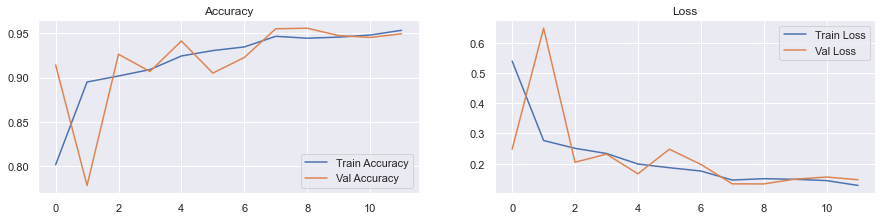

In [13]:
accuracy = model_history.history['categorical_accuracy']
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
val_accuracy = model_history.history['val_categorical_accuracy']

plt.figure(figsize=(15, 7))
plt.subplot(2, 2, 1)
plt.plot(accuracy, label='Train Accuracy')
plt.plot(val_accuracy, label='Val Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(2, 2, 2)
plt.plot(loss, label='Train Loss')
plt.plot(val_loss, label='Val Loss')
plt.legend()
plt.title('Loss')

plt.show()

In [14]:
test_pred = model.predict(x_test)
print(test_pred.shape)

(6000, 6)


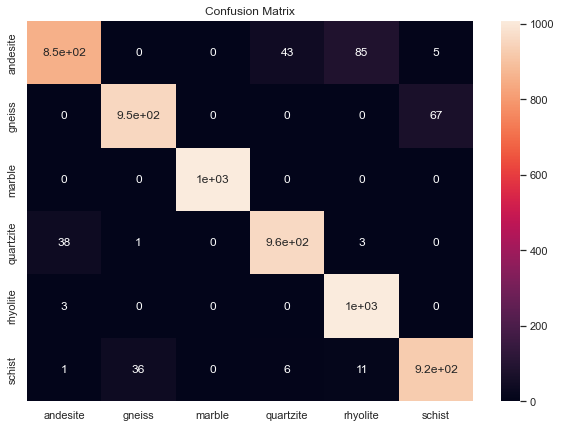

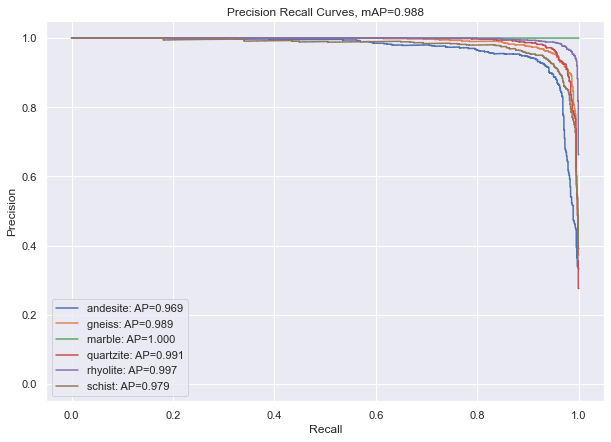

In [15]:
label_d = {v:k for k,v in x_test.class_indices.items()}
y_test = test["Label"].map(x_test.class_indices).tolist()
y_test = np.expand_dims(y_test,axis=-1)
plot_confusion_matrix(test_pred, y_test, label_d)
plot_multiclass_pr_curves(test_pred, y_test, label_d, from_logits=True)

#### From our confusion matrix and Precision-Recall curves, we can see that our mAP score is close to 1. So our model has learned the distinguishing features within our data quite well.

In [16]:
model.save('results/model')

INFO:tensorflow:Assets written to: results/model\assets


In [6]:
#Load model
model = tf.keras.models.load_model('results/model')

# 3. Extract Features

In [7]:
#Create another model that extracts output from last dense layer.
feat_extractor = tf.keras.Model(inputs=model.input, outputs=model.get_layer("fc").output)
feat_extractor.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 64)                0         
_________________________________________________________________
fc (Dense)                   (None, 64)                4160  

In [8]:
def path_to_img(path):
    #Convert image path to PIL image
    img = image.load_img(path, target_size=model.input_shape[1:3])
    return img
    
def img_to_npy(path):
    #Convert image to numpy array
    x = path_to_img(path)
    x = image.img_to_array(x)
    x /= 255
    x = np.expand_dims(x, axis=0)
    return x

def extract_features(df):
    #Extract features from all images in dataset
    paths = df["Path"].tolist()
    feat = [img_to_npy(path) for path in paths]
    feat = np.concatenate(feat) #shape: (29998,28,28,3)
    feat = feat_extractor.predict(feat) #shape: (29998,64)
    return feat

In [16]:
%%time
extracted_features = extract_features(df)
extracted_features.shape

CPU times: total: 11.4 s
Wall time: 16.1 s


(29998, 64)

# 4. Select image and compare similarity metric

In [17]:
#Pick a random image
rand_idx = random.randint(0, len(df)-1)
print("Index Selected: ", rand_idx)

Index Selected:  4169


In [18]:
%%time
img_features = extracted_features[rand_idx,:]
img_features = np.expand_dims(img_features, axis=0)

# Compute pairwise cosine similarity among all features.
sim = cosine_similarity(img_features, extracted_features)
sim = sim.flatten() #shape: (29998,)

CPU times: total: 0 ns
Wall time: 11.5 ms


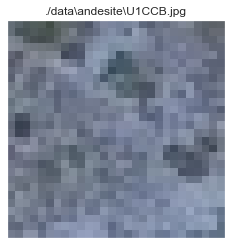

In [19]:
#Plot selected random image
path = df.iloc[rand_idx]["Path"]
img = path_to_img(path)
fig, ax = plt.subplots()
ax.imshow(img)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title(path)
plt.show()

In [20]:
#Select top k similar images
top_k = 10

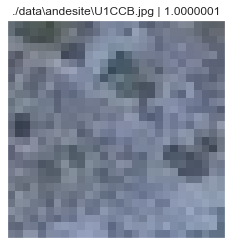

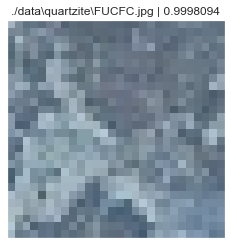

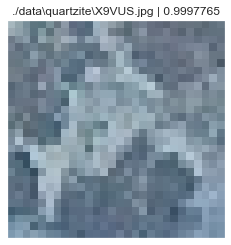

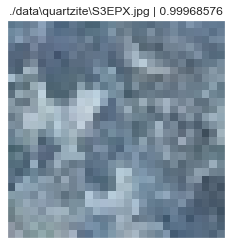

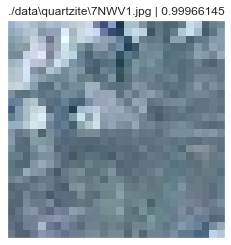

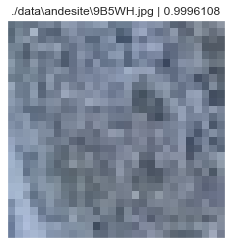

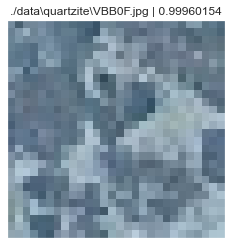

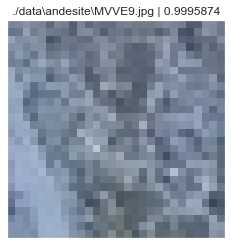

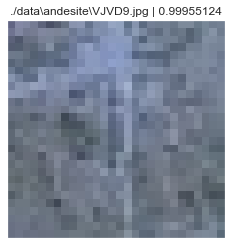

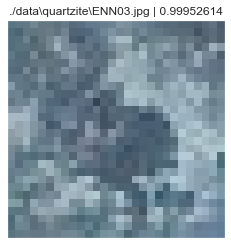

In [21]:
top_k_idx = np.argpartition(sim, -top_k)[-top_k:]
top_k_idx = sorted(top_k_idx, key=lambda x: sim[x], reverse=True)
top_k_val = sim[top_k_idx]

for idx in range(len(top_k_idx)):
    path = df.iloc[top_k_idx[idx]]["Path"]
    img = path_to_img(path)
    fig, ax = plt.subplots()
    ax.imshow(img)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(path + " | " + str(top_k_val[idx]))
    plt.show()

### We see that the top k images match in category and show similar patterns. The first similar image selected is the same image since we compare all pairs.

In [22]:
from sklearn.manifold import TSNE
tsne_transform = TSNE(n_components=2).fit_transform(extracted_features)

C:\Users\Derek\anaconda3\envs\tf_gpu\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Derek\anaconda3\envs\tf_gpu\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


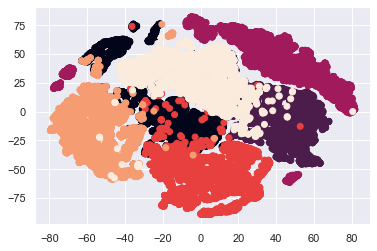

In [23]:
plt.scatter(tsne_transform[:,0], tsne_transform[:,1], c=df["Label"].map(x_test.class_indices).tolist())

In [62]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
x = StandardScaler().fit_transform(extracted_features)
pca_data = PCA(n_components=2).fit_transform(x)

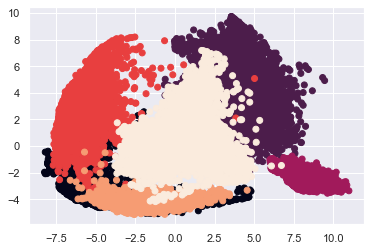

In [63]:
plt.scatter(pca_data[:,0], pca_data[:,1], c=df["Label"].map(x_test.class_indices).tolist())